The complete code involves **training** a PIDeepONet model for solving ODEs/PDEs and generating **predictions**. This code follow the process of:

1. Defining the model architecture using TensorFlow.
2. Creating synthetic data for training, validation, and testing.
3. Training the model using the training dataset with a specified loss function and optimization.
4. Visualizing the loss convergence during training.
5. Making predictions on the test dataset and evaluating the model's performance.    

***Import Dependencies: The code begins by importing the required libraries such as NumPy, TensorFlow, Matplotlib, and others.***

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import tqdm
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

***Define Model Architecture: The create_model function is defined to create the architecture of the Physics-informed DeepONet model. It consists of a branch and trunk network, which are combined to calculate the model's output.***




In [ ]:
def create_model(mean, var, verbose=False):
    """Definition of a DeepONet with fully connected branch and trunk layers.

    Args:
    ----
    mean: dictionary, mean values of the inputs
    var: dictionary, variance values of the inputs
    verbose: boolean, indicate whether to show the model summary

    Outputs:
    --------
    model: the DeepONet model
    """

    # Branch net
    branch_input = tf.keras.Input(shape=(len(mean['cc'])), name="cc")
    branch = tf.keras.layers.Normalization(mean=mean['cc'], variance=var['cc'])(branch_input)
    for i in range(3):
        branch = tf.keras.layers.Dense(50, activation="tanh")(branch)

    # Trunk net
    trunk_input = tf.keras.Input(shape=(len(mean['time'])), name="time")
    trunk = tf.keras.layers.Normalization(mean=mean['time'], variance=var['time'])(trunk_input)
    for i in range(3):
        trunk = tf.keras.layers.Dense(50, activation="tanh")(trunk)

    # Compute the dot product between branch and trunk net
    dot_product = tf.reduce_sum(tf.multiply(branch, trunk), axis=1, keepdims=True)

    # Add the bias
    output = BiasLayer()(dot_product)

    # Create the model
    model = tf.keras.models.Model(inputs=[branch_input, trunk_input], outputs=output)

    if verbose:
        model.summary()

    return model

***Define Custom Layer: The BiasLayer class is defined as a custom Keras layer to add a bias term to the model's output.***

In [ ]:
class BiasLayer(tf.keras.layers.Layer):
    def build(self, input_shape):
        self.bias = self.add_weight(shape=(1,),
                                    initializer=tf.keras.initializers.Zeros(),
                                    trainable=True)
    def call(self, inputs):
        return inputs + self.bias

***Define ODE Residual Calculator: The ODE_residual_calculator function calculates the residual of the governing ordinary differential equation (ODE) based on the model's output and its derivatives.***

ODE_residual_calculator () :
- **forward** running of the DeepONet model : we give the model ({"cc": u, "time": t}) and it outputs : s
- calculate the gradient of s(.) at t & track all operations that involve t
 => ds_dt = tape.gradient(s, t)
- we use @tf.function => to convert the regular python function into a Tebsorflow graph BECAUSE gradient calculation can be quite expensive !



In [ ]:
@tf.function
def ODE_residual_calculator(t, u, u_t, model):
    """ODE residual calculation.

    Args:
    ----
    t: temporal coordinate
    u: input function evaluated at discrete temporal coordinates
    u_t: input function evaluated at t
    model: DeepONet model

    Outputs:
    --------
    ODE_residual: residual of the governing ODE
    """

    with tf.GradientTape() as tape:
        tape.watch(t)
        s = model({"cc": u, "time": t})

    # Calculate gradients
    ds_dt = tape.gradient(s, t)

    # ODE residual
    ODE_residual = ds_dt - u_t

    return ODE_residual

***Define Training Step: The train_step function computes the gradients of the total loss with respect to the model's parameters for a given batch of training data. It also calculates the individual losses for initial conditions (IC) and ODE residuals.***

In [ ]:
@tf.function
def train_step(X, X_init, IC_weight, ODE_weight, model):
    """Calculate gradients of the total loss with respect to network model parameters.

    Args:
    ----
    X: training dataset for evaluating ODE residuals
    X_init: training dataset for evaluating initial conditions
    IC_weight: weight for initial condition loss
    ODE_weight: weight for ODE loss
    model: DeepONet model

    Outputs:
    --------
    ODE_loss: calculated ODE loss
    IC_loss: calculated initial condition loss
    total_loss: weighted sum of ODE loss and initial condition loss
    gradients: gradients of the total loss with respect to network model parameters.
    """
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_weights)

        # Initial condition prediction
        y_pred_IC = model({"cc": X_init[:, 1:-1], "time": X_init[:, :1]})

        # Equation residual
        ODE_residual = ODE_residual_calculator(t=X[:, :1], u=X[:, 1:-1], u_t=X[:, -1:], model=model)

        # Calculate loss
        IC_loss = tf.reduce_mean(keras.losses.mean_squared_error(0, y_pred_IC))
        ODE_loss = tf.reduce_mean(tf.square(ODE_residual))

        # Total loss
        total_loss = IC_loss*IC_weight + ODE_loss*ODE_weight

    gradients = tape.gradient(total_loss, model.trainable_variables)

    return ODE_loss, IC_loss, total_loss, gradients

**Generate Synthetic Data**: Functions like **create_samples** and **generate_dataset** are defined to generate synthetic data for training, validation, and testing. These data include input profiles, time points, and corresponding ODE solutions.

 **create_samples(length_scale, sample_num):
This function generates synthetic data for the input profiles (u(·)) using a Gaussian Process Regressor (GPR) with a given length scale. It generates a specified number of u(·) profiles by sampling from the prior distribution defined by the GPR kernel.**

# Integrating real data

In [ ]:
from google.colab import drive
import pandas as pd
df_cc = pd.read_csv('/content/drive/MyDrive/Warfarin-drug/Physics infoemed DeepONet/Real data with PIDeepONets/value_concentration.csv')
df_time = pd.read_csv('/content/drive/MyDrive/Warfarin-drug/Physics infoemed DeepONet/Real data with PIDeepONets/time.csv')
type(df_time)

pandas.core.frame.DataFrame

**convert data from dataframe to ndarray**

In [ ]:
cc_data = df_cc.to_numpy()
time_data = df_time.to_numpy()

In [ ]:
cc_data

array([[2.54286120e-02],
       [4.00000000e-03],
       [6.00000000e-04],
       [6.20000000e-03],
       [1.90000000e-03],
       [2.40000000e-03],
       [6.40000000e-03],
       [1.40000000e-03],
       [5.00000000e-03],
       [7.60356760e-03],
       [2.58408330e-03],
       [2.62775690e-02],
       [4.97714470e-03],
       [2.69514000e-04],
       [1.73651200e-02],
       [2.76113847e-03],
       [9.37050400e-03],
       [2.76243090e-05],
       [2.13727110e-02],
       [3.92570720e-02],
       [2.04258600e-02],
       [4.79785080e-02],
       [5.52486200e-04],
       [1.32352430e-02],
       [2.13230040e-02],
       [3.10810160e-03],
       [1.26686987e-02],
       [5.80110500e-04],
       [7.81460760e-03],
       [2.52288530e-02],
       [1.11899970e-02],
       [1.69051910e-02],
       [1.46456990e-04],
       [1.76833780e-02],
       [2.28675520e-02],
       [5.80110500e-04],
       [1.18784530e-03],
       [1.58838500e-02],
       [1.18595300e-02],
       [5.90049550e-03],


In [ ]:
time_data

array([[0.        ],
       [0.00416667],
       [0.00555556],
       [0.00833333],
       [0.01111111],
       [0.01666667],
       [0.025     ],
       [0.03333333],
       [0.04166667],
       [0.04759908],
       [0.083     ],
       [0.08333333],
       [0.0876993 ],
       [0.11237356],
       [0.1198895 ],
       [0.1369863 ],
       [0.14700393],
       [0.14935823],
       [0.16081877],
       [0.167     ],
       [0.19582933],
       [0.20140995],
       [0.21470246],
       [0.243149  ],
       [0.24705264],
       [0.25      ],
       [0.2735978 ],
       [0.30805135],
       [0.32748142],
       [0.33976123],
       [0.3574139 ],
       [0.35776848],
       [0.3715512 ],
       [0.42356735],
       [0.42724916],
       [0.45740956],
       [0.48541424],
       [0.49204817],
       [0.49609298],
       [0.49745402],
       [0.5       ],
       [0.5070772 ],
       [0.5072689 ],
       [0.511352  ],
       [0.5167388 ],
       [0.52391505],
       [0.52452165],
       [0.528

In [ ]:
time_data.shape

(100, 1)

In [ ]:
type(time_data)

numpy.ndarray

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

def create_samples(length_scale, sample_num):
    """Create synthetic data for u(·)

    Args:
    ----
    length_scale: float, length scale for RNF kernel
    sample_num: number of u(·) profiles to generate

    Outputs:
    --------
    u_sample: generated u(·) profiles
    """

    # Define kernel with given length scale
    kernel = RBF(length_scale)

    # Create Gaussian process regressor
    gp = GaussianProcessRegressor(kernel=kernel)

    # Collocation point locations
    #X_sample = np.linspace(0, 1, 100).reshape(-1, 1)                           ##########            Changing this line with our real data "cc_data"
    X_sample = cc_data

    # Create samples
    u_sample = np.zeros((sample_num, 100))
    for i in range(sample_num):
        # sampling from the prior directly
        n = np.random.randint(0, 10000)
        u_sample[i, :] = gp.sample_y(X_sample, random_state=n).flatten()

    return u_sample

 **generate_dataset(N, length_scale, ODE_solve=False):
This function generates a dataset for Physics-informed DeepONet training. It creates random fields (u(·) profiles) using the create_samples function and compiles a dataset of t, u(·) profiles, and u(t). Optionally, if ODE_solve is set to True, it also computes the corresponding ODE solution s(·) using the solve_ivp function**

1.   N: Number of u(·) profiles to generate.
2.   length_scale: Length scale for the random field kernel.
3.   ODE_solve: Flag indicating whether to compute the corresponding s(·) using ODE solving.




    



    

In [ ]:
from tqdm import tqdm
from scipy.integrate import solve_ivp

def generate_dataset(N, length_scale, ODE_solve=False):
    """Generate dataset for Physics-informed DeepONet training.

    Args:
    ----
    N: int, number of u(·) profiles
    length_scale: float, length scale for RNF kernel
    ODE_solve: boolean, indicate whether to compute the corresponding s(·)

    Outputs:
    --------
    X: the dataset for t, u(·) profiles, and u(t)
    y: the dataset for the corresponding ODE solution s(·)
    """

    # Create random fields
    random_field = create_samples(length_scale, N)

    # Compile dataset
    X = np.zeros((N*100, 100+2))
    y = np.zeros((N*100, 1))

    for i in tqdm(range(N)):
        u = np.tile(random_field[i, :], (100, 1))
        #t = np.linspace(0, 1, 100).reshape(-1, 1)                               # changing "time" with our real time data"time_data"
        t = time_data

        # u(·) evaluated at t
        u_t = np.diag(u).reshape(-1, 1)

        # Update overall matrix
        X[i*100:(i+1)*100, :] = np.concatenate((t, u, u_t), axis=1)

        # Solve ODE
        t_unique_values = np.unique(t)                                            # time unique values
        if ODE_solve:
            sol = solve_ivp(lambda var_t, var_s: np.interp(var_t, t.flatten(), random_field[i, :]),
                            t_span=[t[0], t[-1]], y0=[0], t_eval=t_unique_values.flatten(), method='RK45') # using time unique values & t[0], t[-1] in place of [0,1]
            y[i*100:(i+1)*100, :] = sol.y[0].reshape(-1, 1)

    return X, y

The "**Create Dataset Objects**" section involves preparing the generated datasets for training by ***converting them into TensorFlow dataset objects*** and performing necessary ***preprocessing steps.***

In [ ]:
# Create training dataset
N_train = 2000
length_scale_train = 0.4
X_train, y_train = generate_dataset(N_train, length_scale_train)

# Create validation dataset
N_val = 100
length_scale_test = 0.4
X_val, y_val = generate_dataset(N_val, length_scale_test)

# Create testing dataset
N_test = 100
length_scale_test = 0.4
X_test, y_test = generate_dataset(N_test, length_scale_test, ODE_solve=True)

100%|██████████| 100/100 [00:00<00:00, 296.89it/s]


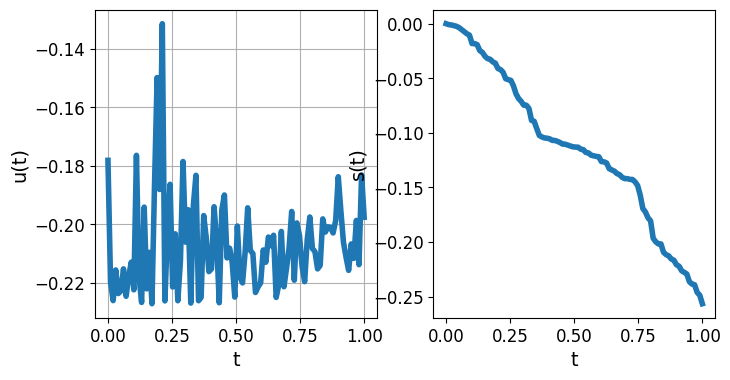

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
index = 25
ax[0].plot(np.linspace(0, 1, 100), X_test[index*100, 1:-1], lw=4)
ax[0].set_xlabel('t', fontsize=14)
ax[0].set_ylabel('u(t)', fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].grid(True)

ax[1].plot(np.linspace(0, 1, 100), y_test[index*100:(index+1)*100], lw=4)
ax[1].set_xlabel('t', fontsize=14)
ax[1].set_ylabel('s(t)', fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=12)

# From here **starts** the added code to have real data

In [ ]:
type(X_train)

numpy.ndarray

In [ ]:
X_train.shape

(200000, 102)

In [ ]:
X_train[1]

array([0.00416667, 0.38385918, 0.38974419, 0.3907106 , 0.3891232 ,
       0.39034014, 0.39019793, 0.38906686, 0.39048238, 0.38946138,
       0.38872882, 0.39014553, 0.38363398, 0.38946785, 0.39080489,
       0.38602917, 0.3900953 , 0.38823449, 0.39087393, 0.38494364,
       0.38027493, 0.38519895, 0.37810726, 0.39072411, 0.387162  ,
       0.38495698, 0.38999694, 0.38731853, 0.39071614, 0.38866987,
       0.38391223, 0.38772818, 0.38615466, 0.39084011, 0.38594226,
       0.38454224, 0.3907163 , 0.39054287, 0.38643382, 0.38754266,
       0.38920754, 0.38906532, 0.38601265, 0.38767876, 0.3908216 ,
       0.38616151, 0.38545484, 0.38851265, 0.3880273 , 0.38873482,
       0.39052489, 0.38693837, 0.38945817, 0.38978816, 0.38823055,
       0.38606415, 0.38813315, 0.38829874, 0.39028391, 0.38999564,
       0.3897799 , 0.38811707, 0.388733  , 0.38747595, 0.38790462,
       0.38738798, 0.39054286, 0.38988955, 0.38720252, 0.38998447,
       0.38903408, 0.38799342, 0.38623659, 0.38964803, 0.38678

# From here **ends** the added code to have real data

Preprocessing steps :
- ***X_train_ini, ini_ds:*** The initial conditions dataset object is created using TensorFlow's tf.data.Dataset.from_tensor_slices function. It contains **initial conditions** data, which are samples where the temporal coordinate is 0. The dataset is **shuffled and batched** for training.

- ***X_train, train_ds:*** The collocation points dataset object is created using the same approach. It includes both the **temporal coordinates and u(·) profiles** for collocation points. The dataset is shuffled and batched for training.

- ***Scaling:*** The **mean** and **variance** of the input features (cc and time) are calculated to scale the data. These statistics are used to normalize the input data in order to improve training stability.

In [ ]:
# Determine batch size
ini_batch_size = int(2000/100)
col_batch_size = 2000

# Create dataset object (initial conditions)
X_train_ini = tf.convert_to_tensor(X_train[X_train[:, 0]==0], dtype=tf.float32)
ini_ds = tf.data.Dataset.from_tensor_slices((X_train_ini))
ini_ds = ini_ds.shuffle(5000).batch(ini_batch_size)


# Create dataset object (collocation points)
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
train_ds = tf.data.Dataset.from_tensor_slices((X_train))
train_ds = train_ds.shuffle(100000).batch(col_batch_size)

# Scaling
mean = {
    'cc': np.mean(X_train[:, 1:-1], axis=0),
    'time': np.mean(X_train[:, :1], axis=0)
}

var = {
    'cc': np.var(X_train[:, 1:-1], axis=0),
    'time': np.var(X_train[:, :1], axis=0)
}

***Define Loss Tracking***: The LossTracking class helps ***track and manage the loss*** values during ***training***. It ***calculates and stores*** the mean total loss, IC loss, and ODE loss.

In [ ]:
from collections import defaultdict

class LossTracking:

    def __init__(self):
        self.mean_total_loss = keras.metrics.Mean()
        self.mean_IC_loss = keras.metrics.Mean()
        self.mean_ODE_loss = keras.metrics.Mean()
        self.loss_history = defaultdict(list)

    def update(self, total_loss, IC_loss, ODE_loss):
        self.mean_total_loss(total_loss)
        self.mean_IC_loss(IC_loss)
        self.mean_ODE_loss(ODE_loss)

    def reset(self):
        self.mean_total_loss.reset_states()
        self.mean_IC_loss.reset_states()
        self.mean_ODE_loss.reset_states()

    def print(self):
        print(f"IC={self.mean_IC_loss.result().numpy():.4e}, \
              ODE={self.mean_ODE_loss.result().numpy():.4e}, \
              total_loss={self.mean_total_loss.result().numpy():.4e}")

    def history(self):
        self.loss_history['total_loss'].append(self.mean_total_loss.result().numpy())
        self.loss_history['IC_loss'].append(self.mean_IC_loss.result().numpy())
        self.loss_history['ODE_loss'].append(self.mean_ODE_loss.result().numpy())

***Configure Training Parameters:*** The training parameters such as the number of epochs, loss weights, and optimizer are set up.

***Training Loop:*** The main training loop runs for the specified number of epochs. It iterates through the training and initial conditions datasets, computes gradients, performs gradient descent, and updates the loss tracking.

***Validation and Callbacks:*** After each epoch, the validation loss is calculated, and callbacks such as learning rate reduction and model checkpointing are applied.

In [ ]:
# Set up training configurations
n_epochs = 300
IC_weight= tf.constant(1.0, dtype=tf.float32)
ODE_weight= tf.constant(1.0, dtype=tf.float32)
loss_tracker = LossTracking()
val_loss_hist = []

# One test sample prediction
pred_profiles = []

# Set up optimizer
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

with tf.device("CPU:0"):

    # Instantiate the PINN model
    PI_DeepONet = create_model(mean, var)
    PI_DeepONet.compile(optimizer=optimizer)

    # Configure callbacks
    _callbacks = [keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=30),
                 tf.keras.callbacks.ModelCheckpoint('NN_model.h5', monitor='val_loss', save_best_only=True)]
    callbacks = tf.keras.callbacks.CallbackList(
                    _callbacks, add_history=False, model=PI_DeepONet)

    # Start training process
    for epoch in range(1, n_epochs + 1):
        print(f"Epoch {epoch}:")

        for X_init, X in zip(ini_ds, train_ds):

            # Calculate gradients
            ODE_loss, IC_loss, total_loss, gradients = train_step(X, X_init,
                                                                IC_weight, ODE_weight,
                                                                PI_DeepONet)
            # Gradient descent
            PI_DeepONet.optimizer.apply_gradients(zip(gradients, PI_DeepONet.trainable_variables))


            # Loss tracking
            loss_tracker.update(total_loss, IC_loss, ODE_loss)

        # Loss summary
        loss_tracker.history()
        loss_tracker.print()
        loss_tracker.reset()

        ####### Validation
        val_res = ODE_residual_calculator(X_val[:, :1], X_val[:, 1:-1], X_val[:, -1:], PI_DeepONet)
        val_ODE = tf.cast(tf.reduce_mean(tf.square(val_res)), tf.float32)

        X_val_ini = X_val[X_val[:, 0]==0]
        pred_ini_valid = PI_DeepONet.predict({"cc": X_val_ini[:, 1:-1], "time": X_val_ini[:, :1]}, batch_size=12800)
        val_IC = tf.reduce_mean(keras.losses.mean_squared_error(0, pred_ini_valid))
        print(f"val_IC: {val_IC.numpy():.4e}, val_ODE: {val_ODE.numpy():.4e}, lr: {PI_DeepONet.optimizer.lr.numpy():.2e}")


        # Callback at the end of epoch
        callbacks.on_epoch_end(epoch, logs={'val_loss': val_IC+val_ODE})
        val_loss_hist.append(val_IC+val_ODE)

        # Test dataset
        pred_test = PI_DeepONet.predict({"cc": X_test[:, 1:-1], "time": X_test[:, :1]}, batch_size=12800)
        print(f"RMSE: {mean_squared_error(y_test.flatten(), pred_test.flatten(), squared=False)}")

        # Predict on one specific train samples
        sample_id = 25
        pred_profiles.append(PI_DeepONet.predict({"cc": X_test[sample_id*100:(sample_id+1)*100, 1:-1],
                                            "time": X_test[sample_id*100:(sample_id+1)*100, :1]}, batch_size=12800))

        # Re-shuffle dataset
        ini_ds = tf.data.Dataset.from_tensor_slices((X_train_ini))
        ini_ds = ini_ds.shuffle(5000).batch(ini_batch_size)

        train_ds = tf.data.Dataset.from_tensor_slices((X_train))
        train_ds = train_ds.shuffle(100000).batch(col_batch_size)

Epoch 1:
IC=2.6639e-02,               ODE=6.2374e-02,               total_loss=8.9013e-02
1/1 [==============================] - 0s 128ms/step
val_IC: 1.1056e-03, val_ODE: 9.1210e-03, lr: 1.00e-03
1/1 [==============================] - 0s 50ms/step
RMSE: 0.06088329275508862
1/1 [==============================] - 0s 26ms/step
Epoch 2:
IC=6.4370e-04,               ODE=3.8604e-03,               total_loss=4.5041e-03
1/1 [==============================] - 0s 29ms/step
val_IC: 5.3893e-04, val_ODE: 3.3608e-03, lr: 1.00e-03
1/1 [==============================] - 0s 52ms/step
RMSE: 0.03765504667117644
1/1 [==============================] - 0s 28ms/step
Epoch 3:
IC=2.9002e-04,               ODE=1.8215e-03,               total_loss=2.1115e-03
1/1 [==============================] - 0s 32ms/step
val_IC: 2.9001e-04, val_ODE: 1.7830e-03, lr: 1.00e-03
1/1 [==============================] - 0s 49ms/step
RMSE: 0.02467264914778635
1/1 [==============================] - 0s 28ms/step
Epoch 4:
IC=1.3831e-0

# Visualize Loss History:

**The history of IC loss, ODE loss, and validation loss is plotted to visualize the training progress. => we plot the loss convergence curves:**

In [ ]:
# History
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(range(n_epochs), loss_tracker.loss_history['IC_loss'])
ax[1].plot(range(n_epochs), loss_tracker.loss_history['ODE_loss'])
ax[2].plot(range(n_epochs), val_loss_hist)
ax[0].set_title('IC Loss')
ax[1].set_title('ODE Loss')
ax[2].set_title('Val Loss')
for axs in ax:
    axs.set_yscale('log')

# We can also see how the **prediction accuracy** for **one** specific target s(·) evolves during the training

**Inspect accuracy on test set**

***Load and Evaluate Model: The trained model is loaded from a saved checkpoint, and predictions are made on a test dataset. The root mean squared error (RMSE) is calculated to evaluate the model's performance.***

Load Trained Model:
The previously trained DeepONet model is loaded from a saved checkpoint using PI_DeepONet.load_weights('NN_model.h5').

Predict on Test Dataset:
  The loaded model is used to make predictions on the test dataset (X_test). The predictions are obtained using the model's predict method with the input features ("cc" and "time"). The predicted output (pred_test) is compared to the ground truth (y_test).

Calculate RMSE:
The root mean squared error (RMSE) is calculated between the predicted outputs (pred_test) and the ground truth (y_test) using the mean_squared_error function. The RMSE provides a measure of the model's performance in terms of how well it approximates the true solution.

**Inspect accuracy on test set :**

In [ ]:
# Create new model instance
PI_DeepONet = create_model(mean, var)

# Reload the saved model
PI_DeepONet.load_weights('NN_model.h5')

# Make prediction
pred_test = PI_DeepONet.predict({"cc": X_test[:, 1:-1], "time": X_test[:, :1]}, batch_size=12800)

# Overall accuarcy
print(f"RMSE: {mean_squared_error(y_test.flatten(), pred_test.flatten(), squared=False):.4e}")

1/1 [==============================] - 0s 160ms/step
RMSE: 2.5173e-02


# Spot Check Predictions: Visualization of Ground Truth and Predictions:

**A set of spot-check plots is generated to visualize the model's predictions for specific samples. For each chosen sample, two plots are created:**

- The first plot shows the original input u(·) profile over time (temporal coordinate).

- The second plot displays a comparison between the ground truth and the model's predictions for the corresponding ODE solution s(·) over time.

***Convergence display***

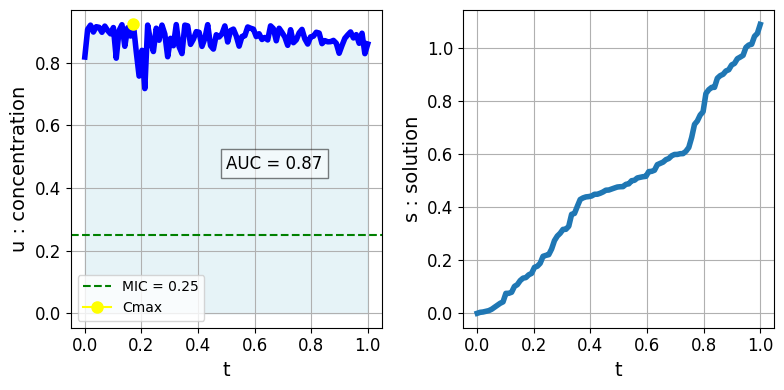

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming X_test contains the concentration and time data, and y_test contains the solution data
index = 25
concentration_data = X_test[index*100, 1:-1]
solution_data = y_test[index*100:(index+1)*100]

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot concentration over time
ax[0].plot(np.linspace(0, 1, 100), concentration_data, lw=4, color='blue')
ax[0].axhline(y=0.25, color='green', linestyle='--', label='MIC = 0.25')
ax[0].plot(np.argmax(concentration_data)/100, np.max(concentration_data), marker='o', markersize=8, color='yellow', label='Cmax')
ax[0].set_xlabel('t', fontsize=14)
ax[0].set_ylabel('u : concentration', fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].grid(True)
ax[0].legend()

# Calculate AUC and plot colored region
auc = np.trapz(concentration_data, dx=1/100)
ax[0].fill_between(np.linspace(0, 1, 100), concentration_data, color='lightblue', alpha=0.3)
ax[0].text(0.5, 0.5, f'AUC = {auc:.2f}', fontsize=12, transform=ax[0].transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Plot solution over time
ax[1].plot(np.linspace(0, 1, 100), solution_data, lw=4)
ax[1].set_xlabel('t', fontsize=14)
ax[1].set_ylabel('s : solution', fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].grid(True)

plt.tight_layout()
plt.show()

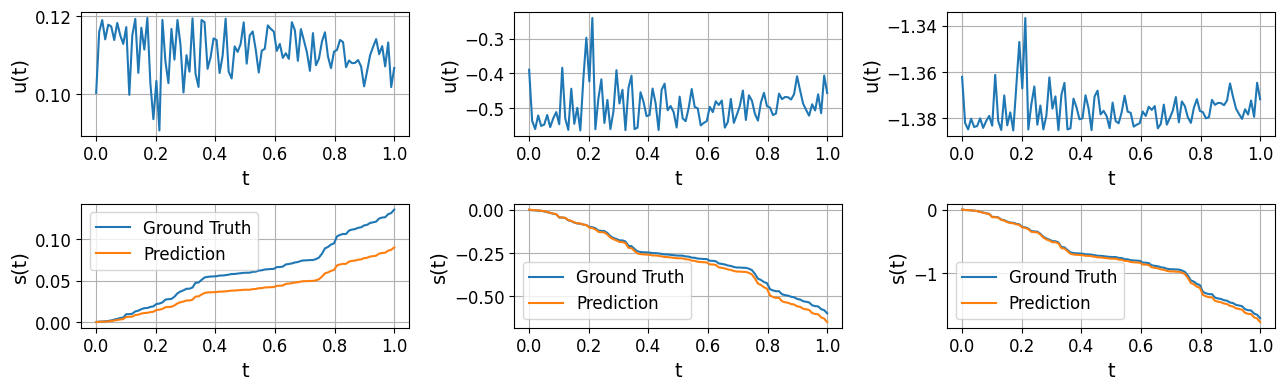

In [ ]:
# Spot check
%matplotlib inline
fig, axs = plt.subplots(2, 3, figsize=(13, 4))
sample_id = np.random.choice(np.arange(0, 100), size=3, replace=False)
for i in range(3):
    ax = axs[0, i]
    ax.plot(np.linspace(0, 1, 100), X_test[sample_id[i]*100, 1:-1])
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('u(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)


    ax = axs[1, i]
    ax.plot(np.linspace(0, 1, 100), y_test[sample_id[i]*100:(sample_id[i]+1)*100, :], label="Ground Truth")
    ax.plot(np.linspace(0, 1, 100), pred_test[sample_id[i]*100:(sample_id[i]+1)*100, :], label="Prediction")
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)
    ax.legend(prop={'size': 12})

plt.tight_layout()
plt.savefig('testing.png', bbox_inches='tight', transparent=True)

***MY INTERPRETATION:***

***THE CONCENTRATION VALUES DOESN'T DECREASE AS IT IS EXPECTED. I THINK BECAUSE I CHOOSED TO SELECT THE 100 FISRT VALUES OF THE CONCENTRATION. SO, I THINK I NEED TO SELECT 100 VALUES FROM THE TOTAL VALUES.***

# Out-of-Distribution Evaluation

***RMSE Comparison for Different Length Scales:
The model's performance is evaluated on test datasets with different length scales. For each length scale, a test dataset is generated using the generate_dataset function.***

In [ ]:
# Create test dataset
N_test = 100
length_scale_test = 0.2
X, y = generate_dataset(N_test, length_scale_test, ODE_solve=True)

100%|██████████| 100/100 [00:00<00:00, 278.71it/s]


***The model's predictions are obtained, and the RMSE is calculated. The RMSE values for different length scales are stored in a list.***

In [ ]:
# Make prediction
pred = PI_DeepONet.predict({"cc": X[:, 1:-1], "time": X[:, :1]}, batch_size=12800)

# Overall accuarcy
print(f"RMSE: {mean_squared_error(y.flatten(), pred.flatten(), squared=False):.4e}")

1/1 [==============================] - 0s 60ms/step
RMSE: 7.7283e-03


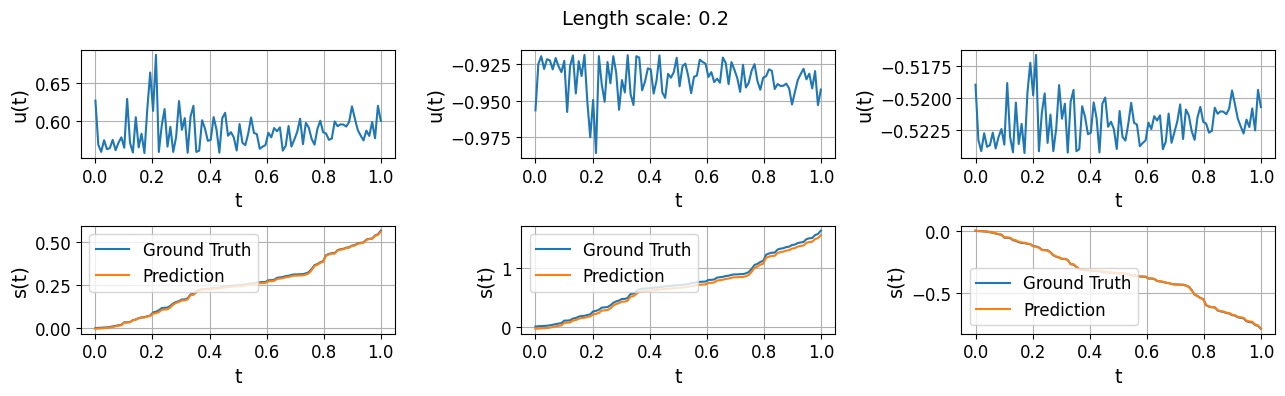

In [ ]:
# Spot check
%matplotlib inline
fig, axs = plt.subplots(2, 3, figsize=(13, 4))
sample_id = np.random.choice(np.arange(0, 100), size=3, replace=False)
for i in range(3):
    ax = axs[0, i]
    ax.plot(np.linspace(0, 1, 100), X_test[sample_id[i]*100, 1:-1])
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('u(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)


    ax = axs[1, i]
    ax.plot(np.linspace(0, 1, 100), y[sample_id[i]*100:(sample_id[i]+1)*100, :], label="Ground Truth")
    ax.plot(np.linspace(0, 1, 100), pred[sample_id[i]*100:(sample_id[i]+1)*100, :], label="Prediction")
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)
    ax.legend(prop={'size': 12})

fig.suptitle(f'Length scale: {length_scale_test}', fontsize=14)
plt.tight_layout()
plt.savefig('testing_OOD.png', bbox_inches='tight', transparent=True)

In [ ]:
length_scale_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
RMSE = []
for length_scale in length_scale_list:
    # Create test dataset
    N_test = 100
    X, y = generate_dataset(N_test, length_scale, ODE_solve=True)

    # Make prediction
    pred = PI_DeepONet.predict({"cc": X[:, 1:-1], "time": X[:, :1]}, batch_size=12800)

    # Overall accuarcy
    RMSE.append(mean_squared_error(y.flatten(), pred.flatten(), squared=False))

100%|██████████| 100/100 [00:00<00:00, 245.69it/s]


1/1 [==============================] - 0s 55ms/step


100%|██████████| 100/100 [00:00<00:00, 283.28it/s]


1/1 [==============================] - 0s 64ms/step


100%|██████████| 100/100 [00:00<00:00, 280.06it/s]


1/1 [==============================] - 0s 54ms/step


100%|██████████| 100/100 [00:00<00:00, 352.35it/s]


1/1 [==============================] - 0s 55ms/step


100%|██████████| 100/100 [00:00<00:00, 339.59it/s]


1/1 [==============================] - 0s 51ms/step


100%|██████████| 100/100 [00:00<00:00, 333.90it/s]


1/1 [==============================] - 0s 51ms/step


100%|██████████| 100/100 [00:00<00:00, 371.85it/s]


1/1 [==============================] - 0s 50ms/step


***Generate RMSE Comparison Bar Plot: Barplot for generalization capability***




***A bar plot is generated to visually compare the RMSE values of the model's predictions for different length scales. The x-axis represents the length scales, and the y-axis represents the RMSE values. This plot helps in assessing how the model's performance varies for different types of data distributions.***

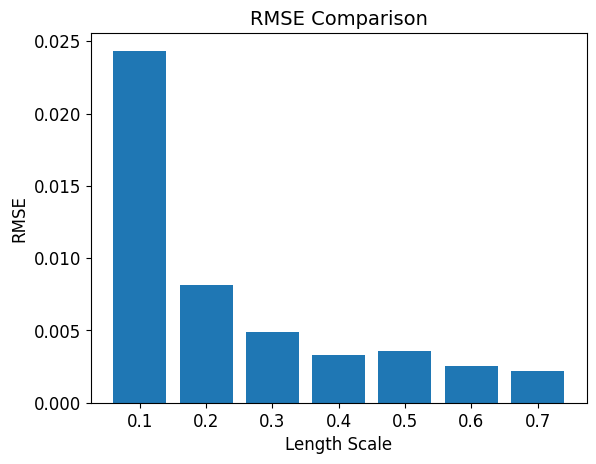

In [ ]:
# Generate bar plot
plt.bar(range(len(RMSE)), RMSE)

# Set x-axis tick labels
plt.xticks(range(len(RMSE)), length_scale_list)

# Set x and y axis labels
plt.xlabel('Length Scale', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

# Set a title for the plot
plt.title('RMSE Comparison', fontsize=14)

# Save the plot
plt.savefig('testing_OOD_bar.png', bbox_inches='tight', transparent=True)